<a href="https://colab.research.google.com/github/sunghwa0508/project/blob/main/Untitled7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

##노래 장르구별 & 추천

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/code/music'.zip

Archive:  /content/drive/My Drive/code/music.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wav  
  

####데이터 시각화

In [4]:
import os

path = 'Data/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith(".wav")]

print ("file_list_py: {}".format(file_list_py))

file_list_py: []


In [105]:
import librosa

y , sr = librosa.load('Data/genres_original/jazz/jazz.00093.wav') # librosa.load() : 오디오 파일을 로드한다.

print(y)
print(len(y))
print('Sampling rate (Hz): %d' %sr)
print('Audio length (seconds): %.2f' % (len(y) / sr)) #음악의 길이(초) = 음파의 길이/Sampling rate

[ 0.00921631  0.00726318 -0.00234985 ...  0.00167847 -0.03924561
 -0.05404663]
661794
Sampling rate (Hz): 22050
Audio length (seconds): 30.01


In [106]:
import IPython.display as ipd #음악듣기
ipd.Audio(y, rate=sr)

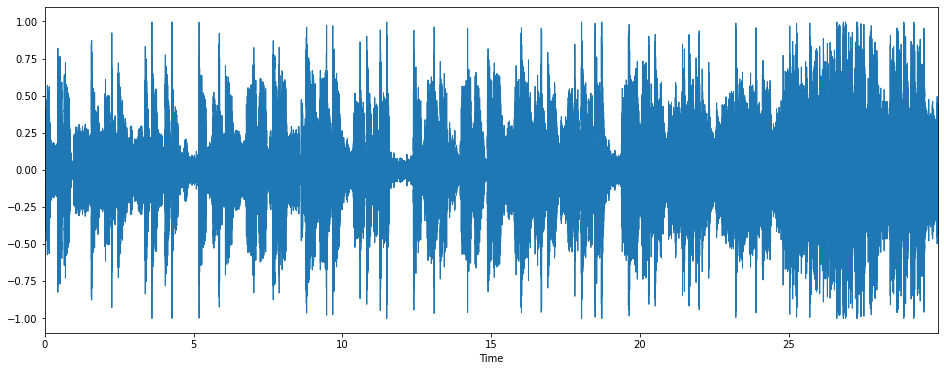

In [9]:
#2D 음파 그래프

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize =(16,6))
librosa.display.waveplot(y=y,sr=sr)
plt.show()

(1025, 1293)


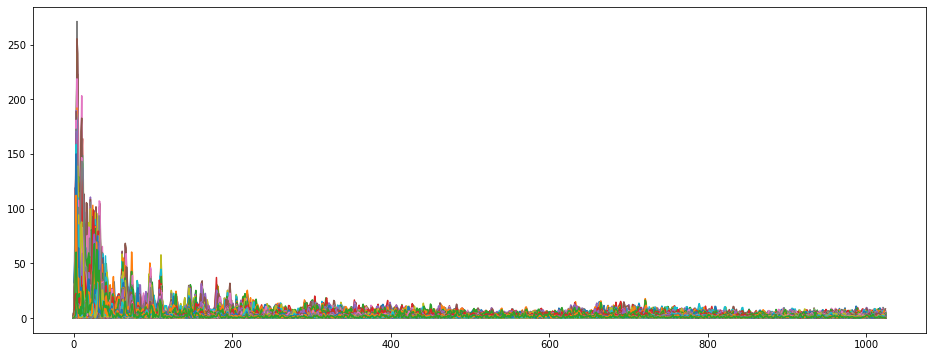

In [10]:
#2-4. Fourier Transform(푸리에 변환)
#* 시간 영역 데이터를 주파수 영역으로 변경 : time(시간) domain -> frequency(진동수) domain 변경 시 얻는 정보가 많아져 분석 용이.

#* y축: 주파수(로그 스케일)

#* color축:데시벨(진폭)

import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) #n_fft : window size / 이 때, 음성의 길이를 얼마만큼으로 자를 것인가? 를 window라고 부른다.


print(D.shape)

plt.figure(figsize=(16,6))
plt.plot(D)
plt.show()

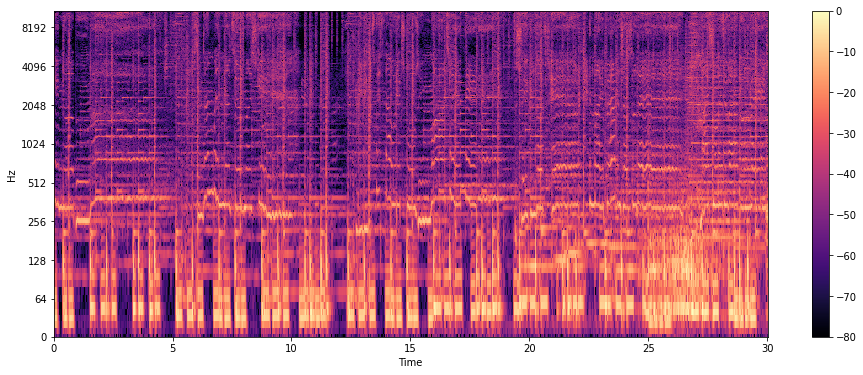

In [11]:
#2-5.Spectogram
#* 시간에 따른 신호 주파수의 스펙트럼 그래프

#* 다른 이름 : Sonographs, Voiceprints, Voicegrams

DB = librosa.amplitude_to_db(D, ref=np.max) #amplitude(진폭) -> DB(데시벨)로 바꿔라

plt.figure(figsize=(16,6))
librosa.display.specshow(DB,sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

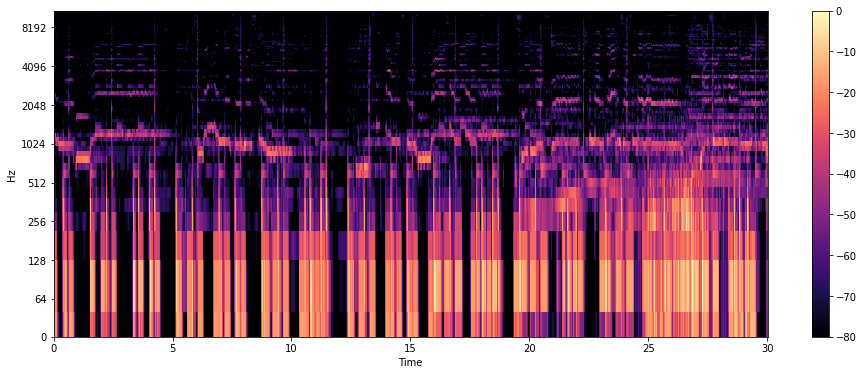

In [12]:
#Mel Spectogram
#*Spectogram의 y축을 Mel Scale로 변환한 것(Non-linear transformation)

#*Mel Scale : https://newsight.tistory.com/294

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr,hop_length=512, x_axis='time',y_axis='log')
plt.colorbar()
plt.show()

length (661504,), sample-rate 22050


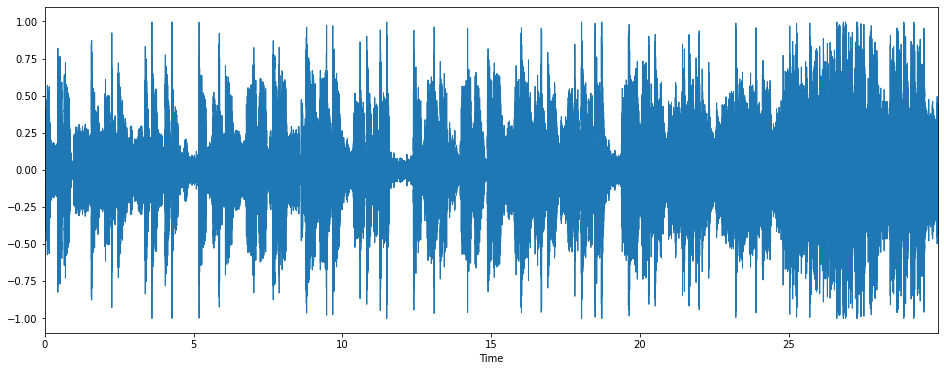

In [56]:
def plot_sound(path):
    plt.figure(figsize=(16, 6))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveplot(x, sr=sr)
    
    return x

pop_path = 'Data/genres_original/pop/pop.00000.wav'
pop_audio = plot_sound(pop_path)
ipd.Audio(pop_path)

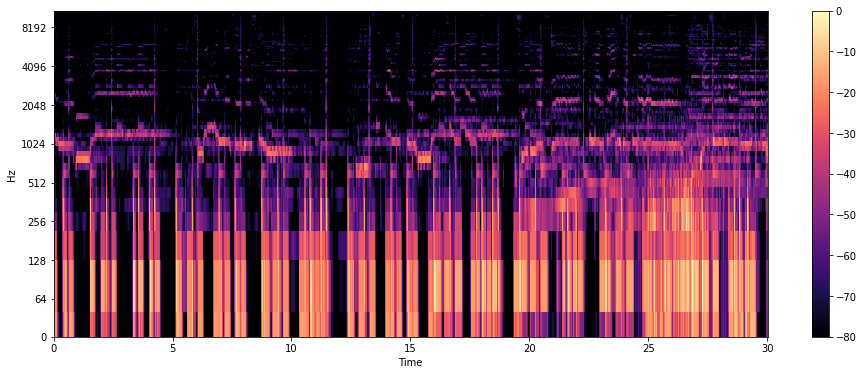

In [13]:
#pop Mel Spectogram

y, sr = librosa.load('Data/genres_original/pop/pop.00000.wav')
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr,hop_length=512, x_axis='time',y_axis='log')
plt.colorbar()
plt.show()


In [57]:
#3. 오디오 특성 추출(Audio Feature Extraction)

#Tempo(BPM)
tempo , _ = librosa.beat.beat_track(y,sr=sr)     
print(tempo)

63.02400914634146


In [58]:
#3-2. Zero Crossing Rate
#* 음파가 양에서 음으로 또는 음에서 양으로 바뀌는 비율

zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings)) # 음 <-> 양 이동한 횟수

[False False False ...  True  True  True]
20322


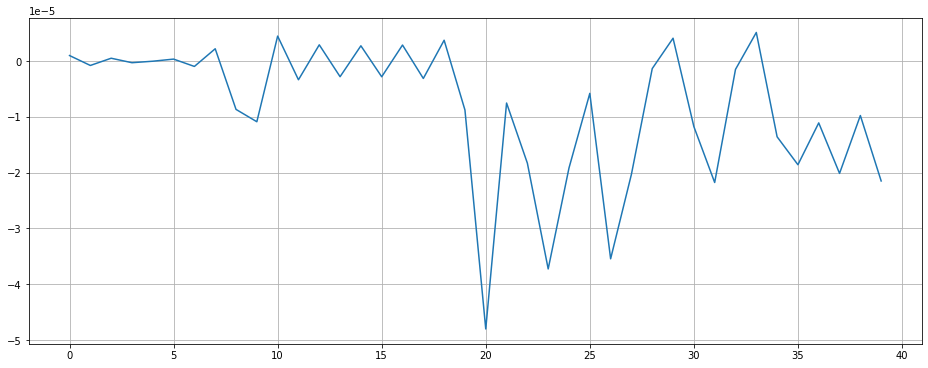

In [59]:
n0 = 9000
n1 = 9040

plt.figure(figsize=(16,6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()

In [60]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False) #n0 ~ n1 사이 zero crossings 
print(sum(zero_crossings))

21


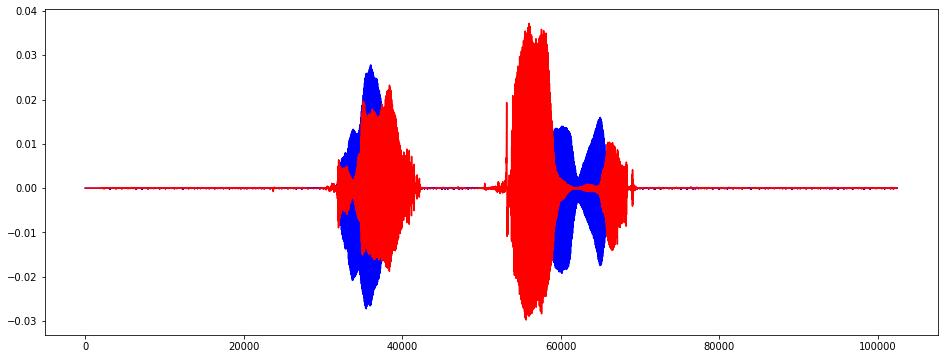

In [61]:
#3-3. Harmonic and Percussive Components

#* Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)

#* Percussives: 리듬과 감정을 나타내는 충격파

y_harm, y_perc = librosa.effects.hpss(y)

plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

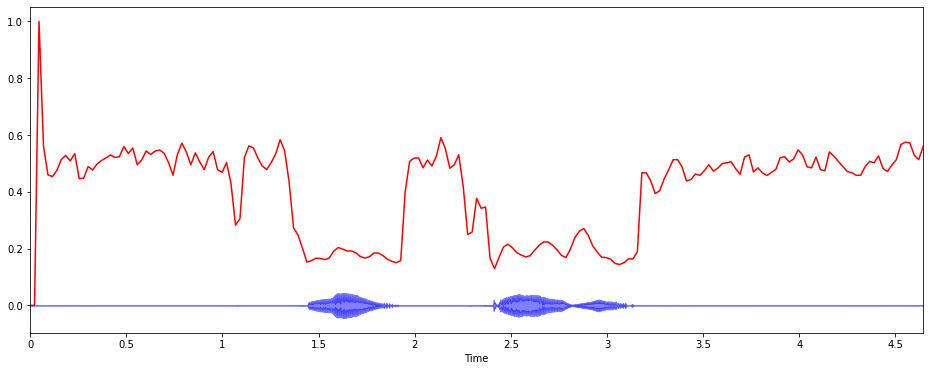

In [62]:
#3-4.Spectral Centroid


#* 소리를 주파수 표현했을 때, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표

#* 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실린다.

spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

#Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)    #sk.minmax_scale() : 최대 최소를 0 ~ 1 로 맞춰준다.

plt.figure(figsize=(16,6))
librosa.display.waveplot(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

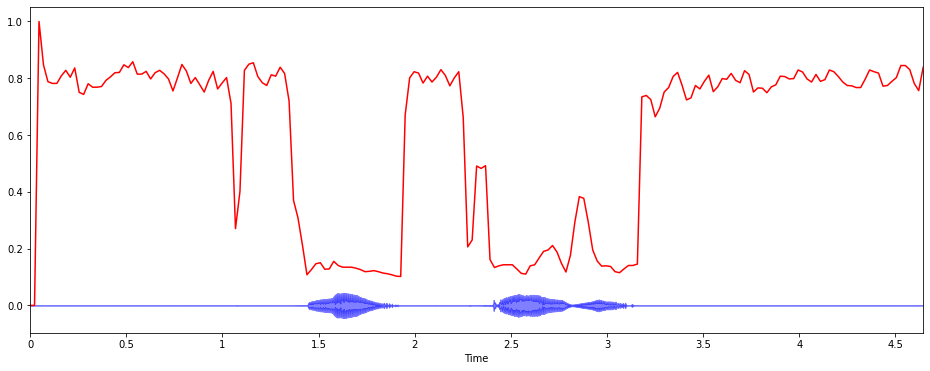

In [63]:
#Spectral Rolloff 신호모양 측정

spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]

plt.figure(figsize=(16,6))
librosa.display.waveplot(y,sr=sr,alpha=0.5,color='b')
plt.plot(t, normalize(spectral_rolloff),color='r')
plt.show()

mean: 0.58
var: 0.06


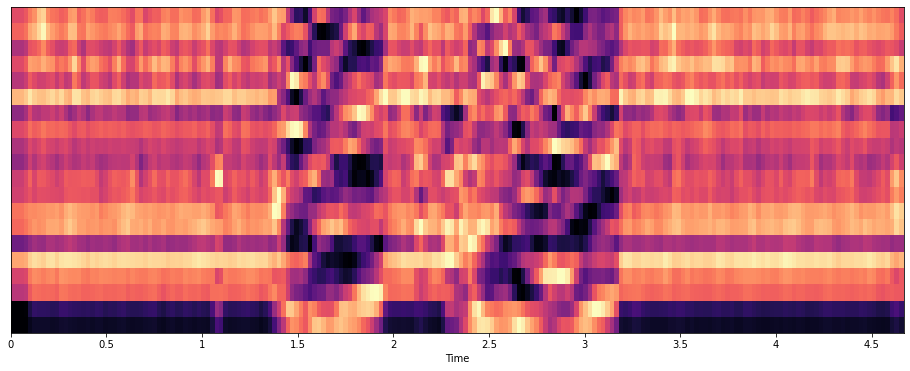

In [64]:
#Mel-Frequency Cepstral Coefficients(MFCCs)

#* MFCCs는 특징들의 작은 집합(약 10-20)으로 스펙트럴 포곡선의 전체적인 모양을 축약하여 보여준다.

#* 사람의 청각 구조를 반영하여 음성 정보 추출

mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs,axis=1)

print('mean: %.2f' % mfccs.mean())
print('var: %.2f' % mfccs.var())

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs,sr=sr, x_axis='time')
plt.show()

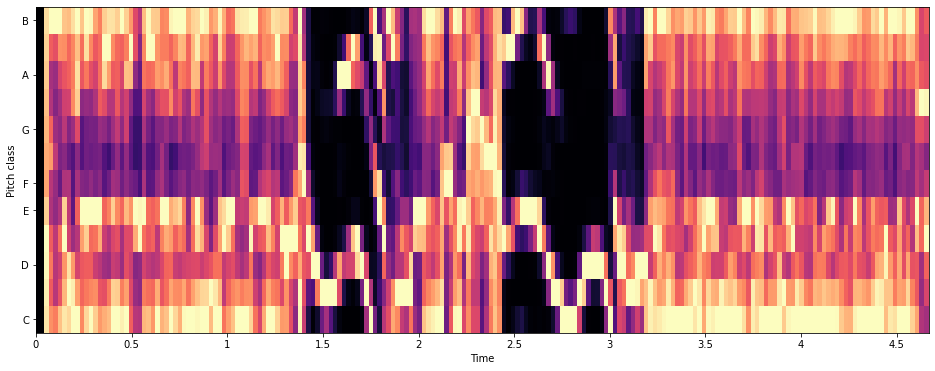

In [65]:
#Chroma Frequencies

chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram,x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

###음악 장르 분류

In [143]:
#io와 pandas 모듈 import
import io
import pandas as pd

#pandas read_csv로 불러오기
data = pd.read_csv('/content/drive/My Drive/code/features_3_sec.csv')
data.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [78]:
df = data[['filename','label']]
df['label'].value_counts()

reggae       1000
metal        1000
blues        1000
pop          1000
jazz         1000
disco         999
hiphop        998
classical     998
rock          998
country       997
Name: label, dtype: int64

장르

Blues :0/
Classical :1/
Country :2/
Disco :3/
Hiphop :4/
Jazz :5/
Metal:6/
Pop :7/
Reggae :8/
Rock :9/

In [149]:
data.label.unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

범주형 데이터 인코더

In [86]:
#음악 장르 분류 알고리즘

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [141]:
df.label.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [87]:
X = data.drop(columns=['filename','length','label']) 
y = data['label'] #장르명

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns=X.columns)

X.head()

chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0          0.355399         0.716757  ...     0.506746    0.047781
1          0.367322         0.670347  ...     0.593029    0.065548
2          0.373159         0.728067  ...     0.546264    0.036062
3          0.399349         0.677066  ...     0.562204    0.034873
4          0.355668         0.689113  ...     0.517913    0.031713

[5 rows x 57 columns]

In [89]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train, y_test = train_test_split(X,y , test_size=0.3, random_state=110)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6993, 57) (6993,)
(2997, 57) (2997,)


In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model.fit(X_train, y_train) #학습

y_pred = model.predict(X_test) #검증

print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

Accuracy: 0.81


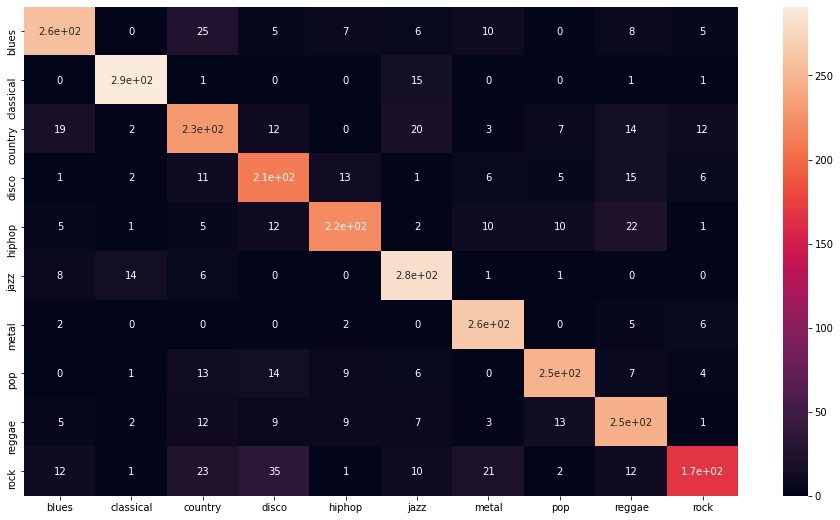

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(16,9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"],
    yticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
)
plt.show()

In [178]:
for feature, importance in zip(X_test.columns, model.feature_importances_):
  print('%s: %.2f' % (feature, importance))

chroma_stft_mean: 0.05
chroma_stft_var: 0.02
rms_mean: 0.04
rms_var: 0.04
spectral_centroid_mean: 0.02
spectral_centroid_var: 0.03
spectral_bandwidth_mean: 0.04
spectral_bandwidth_var: 0.01
rolloff_mean: 0.03
rolloff_var: 0.03
zero_crossing_rate_mean: 0.02
zero_crossing_rate_var: 0.01
harmony_mean: 0.02
harmony_var: 0.03
perceptr_mean: 0.03
perceptr_var: 0.06
tempo: 0.01
mfcc1_mean: 0.03
mfcc1_var: 0.03
mfcc2_mean: 0.02
mfcc2_var: 0.01
mfcc3_mean: 0.02
mfcc3_var: 0.02
mfcc4_mean: 0.04
mfcc4_var: 0.02
mfcc5_mean: 0.01
mfcc5_var: 0.02
mfcc6_mean: 0.02
mfcc6_var: 0.02
mfcc7_mean: 0.01
mfcc7_var: 0.01
mfcc8_mean: 0.02
mfcc8_var: 0.01
mfcc9_mean: 0.02
mfcc9_var: 0.01
mfcc10_mean: 0.01
mfcc10_var: 0.01
mfcc11_mean: 0.02
mfcc11_var: 0.01
mfcc12_mean: 0.02
mfcc12_var: 0.01
mfcc13_mean: 0.01
mfcc13_var: 0.01
mfcc14_mean: 0.01
mfcc14_var: 0.00
mfcc15_mean: 0.01
mfcc15_var: 0.00
mfcc16_mean: 0.01
mfcc16_var: 0.01
mfcc17_mean: 0.01
mfcc17_var: 0.01
mfcc18_mean: 0.01
mfcc18_var: 0.01
mfcc19_mean: 0

딥러닝

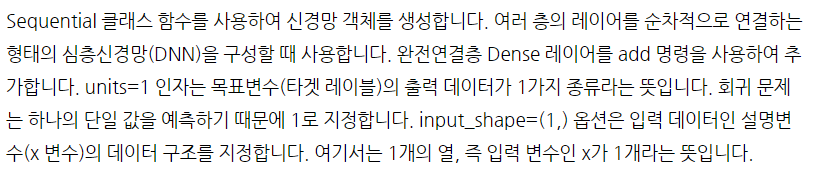

In [116]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


model = Sequential()
model.add(Flatten(input_shape=(57,)))
model.add(Dense(512, activation='relu', input_dim=100))
model.add(Dense(256, activation='sigmoid'))
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              #다중 클래스 분류, 
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 57)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               29696     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
Total params: 161,024
Trainable params: 161,024
Non-trainable params: 0
_________________________________________________________________


In [112]:
run = model.fit(X_train,y_train,
                validation_data = (X_test,y_test),
                epochs = 100,
                batch_size = 32)

Epoch 1/100
219/219 [==============================] - 10s 6ms/step - loss: 2.8225 - accuracy: 0.2195 - val_loss: 1.6008 - val_accuracy: 0.4331
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 1.5221 - accuracy: 0.4492 - val_loss: 1.3985 - val_accuracy: 0.4932
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 1.3230 - accuracy: 0.5156 - val_loss: 1.2403 - val_accuracy: 0.5536
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 1.2194 - accuracy: 0.5610 - val_loss: 1.1843 - val_accuracy: 0.5913
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 1.1415 - accuracy: 0.5938 - val_loss: 1.1235 - val_accuracy: 0.6086
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 1.0931 - accuracy: 0.6112 - val_loss: 1.0801 - val_accuracy: 0.6146
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 1.0382 - accuracy: 0.6334 - val_loss: 1.0521 - val_accuracy: 0.634

In [162]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"The test Loss is : {test_error} ")
print(f"test_accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 0.5234 - accuracy: 0.8188
The test Loss is : 0.5234359502792358 
test_accuracy: 0.8188188076019287


Blues :0/
Classical :1/
Country :2/
Disco :3/
Hiphop :4/
Jazz :5/
Metal:6/
Pop :7/
Reggae :8/
Rock :9/

In [169]:
results = model.predict_classes(X_train) #_on_batch
print(f"예상 인덱스: {results[5]}", )

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


예상 인덱스: 9


In [170]:
#노래 추천: 벡터 유사도가 높은 상위 5개
df_30 = pd.read_csv('Data/features_3_sec.csv', index_col='filename')

labels = df_30[['label']]
df_30 = df_30.drop(columns=['length','label'])

df_30_scaled = sklearn.preprocessing.scale(df_30)  #평균 0 , 표준편차 1 

df_30 = pd.DataFrame(df_30_scaled, columns=df_30.columns)

df_30.head()

chroma_stft_mean  chroma_stft_var  ...  mfcc20_mean  mfcc20_var
0         -0.487808         0.640520  ...     0.128414   -0.291781
1         -0.403142         0.131835  ...     1.275780    0.056425
2         -0.361694         0.764491  ...     0.653907   -0.521458
3         -0.175714         0.205477  ...     0.865880   -0.544744
4         -0.485895         0.337521  ...     0.276899   -0.606692

[5 rows x 57 columns]

In [171]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(df_30)   #벡터의 유사도 , 즉 벡터간의 각도를 통해 추정 cos0 =1 이므로 1에 가까울 수록 유사 / cos180 = -1 이므로 -1에 가까울 수록 다르다.

sim_df = pd.DataFrame(similarity, index=labels.index, columns=labels.index)

sim_df.head()

filename           blues.00000.0.wav  ...  rock.00099.9.wav
filename                              ...                  
blues.00000.0.wav           1.000000  ...          0.353021
blues.00000.1.wav           0.566223  ...          0.329800
blues.00000.2.wav           0.574240  ...          0.192676
blues.00000.3.wav           0.762002  ...          0.327122
blues.00000.4.wav           0.761645  ...          0.380534

[5 rows x 9990 columns]

In [211]:
def find_similar_songs(name, n=5):
  series = sim_df[name].sort_values(ascending=False)

  series = series.drop(name)

  return series.head(n).to_frame()

abc = find_similar_songs('classical.00000.0.wav')
abc

classical.00000.0.wav
filename                                    
classical.00021.1.wav               0.707452
rock.00023.9.wav                    0.705155
classical.00000.6.wav               0.694787
classical.00023.8.wav               0.679866
classical.00000.3.wav               0.674953

In [205]:
import IPython.display as ipd #음악듣기
ipd.Audio('Data/genres_original/classical/classical.00000.wav')

In [207]:
import IPython.display as ipd #음악듣기
ipd.Audio('Data/genres_original/classical/classical.00021.wav')



---
###**음성 인식**

####다운로드들

In [32]:
pip install --upgrade speechrecognition

     |████████████████████████████████| 32.8MB 84kB/s 


In [33]:
pip install gTTs

In [34]:
pip install playsound

In [35]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 184 kB of archives.
After this operation, 891 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Fetched 184 kB in 2s (105 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to 

In [36]:
!pip install pyaudio

  Created wheel for pyaudio: filename=PyAudio-0.2.11-cp37-cp37m-linux_x86_64.whl size=52572 sha256=33444de50860be4502fcaf8034b123fa3343855a737903b8e802415c6187de05
  Stored in directory: /root/.cache/pip/wheels/f4/a8/a4/292214166c2917890f85b2f72a8e5f13e1ffa527c4200dcede
Successfully built pyaudio


In [37]:
pip install pydub

In [212]:
import speech_recognition as sr

r = sr.Recognizer()

#harvard = sr.AudioFile('/content/drive/My Drive/code/audio_files_harvard.wav')
harvard = sr.AudioFile('/content/drive/My Drive/code/sound.wav')
#harvard = sr.AudioFile('/content/drive/My Drive/code/book.wav')

with harvard as source:
    audio = r.record(source)

In [213]:
import librosa

y , sr = librosa.load('/content/drive/My Drive/code/sound.wav') # librosa.load() : 오디오 파일을 로드한다.

print(y)
print(len(y))
print('Sampling rate (Hz): %d' %sr)
print('Audio length (seconds): %.2f' % (len(y) / sr)) #음성의 길이(초) = 음파의 길이/Sampling rate

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  3.9566294e-07
 -3.3378296e-07  3.8159237e-07]
102400
Sampling rate (Hz): 22050
Audio length (seconds): 4.64


In [214]:
import IPython.display as ipd #음성듣기
ipd.Audio(y, rate=sr)

In [215]:
type(audio)

speech_recognition.AudioData

In [216]:
with harvard as source:
    audio1 = r.record(source, duration=4)
    audio2 = r.record(source, duration=4)

In [217]:
with harvard as source:
    audio = r.record(source, offset=0, duration=4)
recog = r.recognize_google(audio)

r.recognize_google(audio)

'hello how are you'

In [223]:
ggg = abc.index[0]

if "hello" in recog:
  print("i am good, thank you")

elif "Recommend me a song." in recog:

  print(ggg)

i am good, thank you


In [224]:
ggg

'classical.00021.1.wav'

In [225]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class

tts = gTTS(ggg) #Provide the string to convert to speech #lang='ko'
tts.save('1.wav') #save the string converted to speech as a .wav file
#  filename='voice.mp3' 파일이름으로 지정해도 됨
sound_file = '1.wav'
Audio(sound_file, autoplay=True) 

#Autoplay = True will play the sound automatically
#If you would not like to play the sound automatically, simply pass Autoplay = False.